In [3]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#Modeling
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.validation import check_X_y, check_is_fitted


In [4]:
train = pd.read_csv('/Users/karen/Desktop/datamining/cw1/comment/train.csv')
test = pd.read_csv('/Users/karen/Desktop/datamining/cw1/comment/test.csv')
subm = pd.read_csv('/Users/karen/Desktop/datamining/cw1/comment/sample_submission.csv')

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Class Imbalance

In [6]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


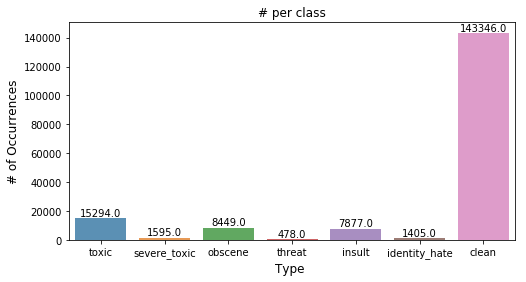

In [7]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Undersampleing

In [8]:
count_toxic_0, count_toxic_1 = train['toxic'].value_counts()
toxic_0 = train[train['toxic'] == 0]
toxic_1 = train[train['toxic'] == 1]
print(len(toxic_0))
print(len(toxic_1))

144277
15294


In [9]:
toxic_0_under = toxic_0.sample(count_toxic_1)
train_under = pd.concat([toxic_0_under, toxic_1], axis=0)
#print(train_under[COMMENT])

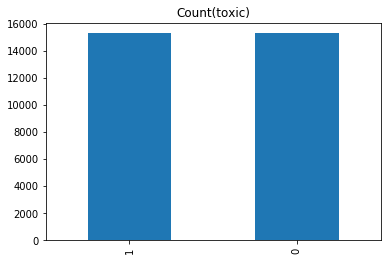

In [10]:
train_under.toxic.value_counts().plot(kind='bar', title='Count(toxic)')

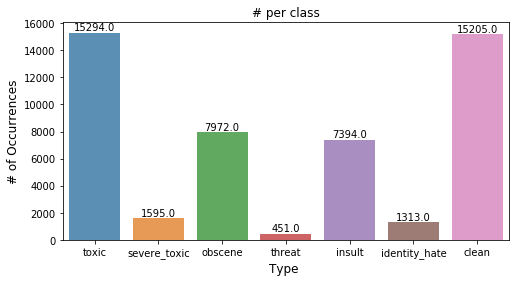

In [11]:
x=train_under.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [12]:
#train_under.head()
lens = train_under.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(349.22302863868185, 601.9307327854151, 5000)

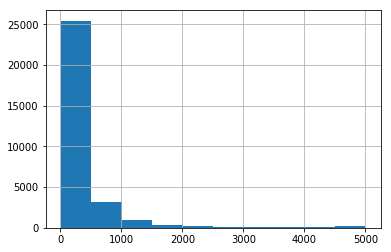

In [13]:
lens.hist();

In [14]:
# label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# train_under['none'] = 1-train_under[label_cols].max(axis=1)
# train_under.describe()

In [15]:
len(train_under),len(test)

(30588, 153164)

In [16]:
# from sklearn.datasets import make_classification
# from sklearn.decomposition import PCA
# from imblearn.under_sampling import TomekLinks

In [17]:
# f_values = train[["severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
# t_values = train['toxic'].values
# tl = TomekLinks(return_indices=True, ratio='majority')
# fv_tl, tv_tl, id_tl = tl.fit_sample(f_values, t_values)
# print(len(id_tl))
# print(len(tv_tl))

In [18]:
COMMENT = 'comment_text'
train_under[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)
#print(test)

In [19]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [27]:
n = train_under.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train_under[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [28]:
trn_term_doc, test_term_doc

(<30588x102276 sparse matrix of type '<class 'numpy.float64'>'
 	with 2634298 stored elements in Compressed Sparse Row format>,
 <153164x102276 sparse matrix of type '<class 'numpy.float64'>'
 	with 13311727 stored elements in Compressed Sparse Row format>)

In [29]:
# def pr(y_i, y):
#     p = x[y==y_i].sum(0)
#     return (p+1) / ((y==y_i).sum()+1)

In [30]:
x = trn_term_doc
test_x = test_term_doc

In [31]:
#custom NB model
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    

model = NbSvmClassifier(C=2, dual=True, n_jobs=-1)

In [32]:
# def get_mdl(y):
#     y = y.values
#     r = np.log(pr(1,y) / pr(0,y))
#     m = LogisticRegression(C=4, dual=True)
#     x_nb = x.multiply(r)
#     return m.fit(x_nb, y), r
    

In [33]:
#set the target columns
TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y=train_under[TARGET_COLS]

In [62]:
from scipy import sparse
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.4, random_state=2019)
# print(X_train.shape[0])
# print(y_valid)
train_acc = []
valid_acc = []
scores = []
preds_test = np.zeros((test_x.shape[0], len(TARGET_COLS)))

preds_train = np.zeros((X_train.shape[0], y_train.shape[1]))
preds_valid = np.zeros((X_valid.shape[0], y_train.shape[1]))

for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    preds_test[:,i] = model.predict_proba(test_x)[:,1]
    
#     print(preds_valid[:,i])
#     print(y_train[j].values)
    
    vv=np.array(y_valid[j].values)
    tt=np.array(y_train[j].values)
    
    accuracy_valid = accuracy_score(vv,preds_valid[:,i].round())
    accuracy_train = accuracy_score(tt,preds_train[:,i].round())

 #   score = model.score(test_x,test_x[j])
#   valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
#   print('TrainAccuracy=accuracy_train:', accuracy_train)
#   print('ValidAccuracy=accuracy_valid:', accuracy_valid)
#   print('Score=score:', score)

    train_acc.append(accuracy_valid)
    valid_acc.append(accuracy_train)
    #scores.append(score)
print('mean column Train accuracy:', np.mean(train_acc))
print('mean column Valid accuracy:', np.mean(valid_acc))
#print('mean column Score:', np.mean(scores))





Class:= toxic


/Users/karen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Class:= severe_toxic


/Users/karen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Class:= obscene


/Users/karen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Class:= threat


/Users/karen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Class:= insult


/Users/karen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Class:= identity_hate


/Users/karen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


mean column Train accuracy: 0.9322899640405362
mean column Valid accuracy: 0.9746712438244695


In [ ]:
# from sklearn import metrics

# preds = np.zeros((len(test), len(label_cols)))

# for i, j in enumerate(label_cols):
#     X_train, X_valid, y_train, y_valid = train_test_split(x, train_under[j], test_size=0.33, random_state=2018)

#     print('fit', j)
#     m,r = get_mdl(y_train)
#     preds_test[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

#     print('score',m.score(test_x.multiply(r), preds[:,i]))
#     #print("Accuracy:",metrics.accuracy_score(train_under[j], preds[:,i]))





In [64]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds_test, columns = TARGET_COLS)], axis=1)
submission.to_csv('/Users/karen/Desktop/datamining/cw1/comment/submission.csv', index=False)